# Predicting Molecular Constants, Heat Capacity, and Partition Function 

### Part 1: Predict the molecular constants 

In [1]:
# Importing Core Libraries 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Importing Machine Learning Libraries 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.optimize import curve_fit

In [3]:
# Download File
import requests
import shutil

url = 'https://exomol.com/db/C2/12C2/8states/12C2__8states.states.bz2'
file_name = '12C2_8states.bz2'

def download_file(url, filename):
    with requests.get(url, stream=True) as response:
            if response.status_code == 200:
                with open(filename, 'wb') as f:
                    shutil.copyfileobj(response.raw, f)
                print(f"File downloaded successfully: {filename}")
            else:
                print(f"Failed to download file. Status code: {response.status_code}")
download_file(url, file_name)

File downloaded successfully: 12C2_8states.bz2


In [4]:
# Extract File
import bz2, shutil
compressed_file = '12C2_8states.bz2'
extracted_file = '12C2_8states.states'

with bz2.BZ2File(compressed_file, 'rb') as fr, open(extracted_file,"wb") as fw:
    shutil.copyfileobj(fr,fw)
print(f'File extracted sucessfully: {extracted_file}')

File extracted sucessfully: 12C2_8states.states


In [5]:
# Loading the Dataset into Panda Frame
df = pd.read_csv('12C2_8states.states', sep=r'\s+')
#Display Entire Data set
print(df.head())

   1     0.000000  1.1  0  0.009813          Inf  0.0000  +  e  X(1SIGMA+g)  \
0  2  1827.487599    1  0    0.0009  1705.800000     0.0  +  e  X(1SIGMA+g)   
1  3  3626.681661    1  0    0.0013  1080.400000     0.0  +  e  X(1SIGMA+g)   
2  4  5396.685747    1  0    0.0014    13.408000     0.0  +  e  X(1SIGMA+g)   
3  5  6250.143654    1  0    0.0017     0.000018     0.0  +  e  b(3SIGMA-g)   
4  6  7136.350333    1  0    0.0010     0.651780     0.0  +  e  X(1SIGMA+g)   

   0.1  0.2  0.3  0.4  F1  0.5  d   0.000000.1  
0    1    0    0    0  F1    0  m  1827.480518  
1    2    0    0    0  F1    0  m  3626.660054  
2    3    0    0    0  F1    0  m  5396.601921  
3    0    0    0    0  F3    1  m  6250.303047  
4    4    0    0    0  F1    0  m  7136.190327  


In [6]:
# Correct column mapping from reference article of database: https://arxiv.org/abs/2406.06347
df.columns = [
    'State_ID',        # i
    'Energy_cm-1',     # 𝐸̃
    'Degeneracy',      # g
    'J',              # Total angular momentum quantum number
    'Uncertainty_cm-1', # unc
    'Lifetime_s',      # τ
    'Lande_g',         # g (Landé g-factor)
    'Parity',          # +/−
    'Symmetry_Type',   # e/f
    'Electronic_State', # State
    'QN_v',           # ν
    'QN_Lambda',      # Λ
    'QN_Sigma',       # Σ
    'QN_Omega',       # Ω
    'F_Label',        # Abbr
    'Other_Type1',    
    'Other_Type2',     # Other type (m)
    'Reference_Energy' # 𝐸̃₀
]
print(df.head())
print(df.info())

   State_ID  Energy_cm-1  Degeneracy  J  Uncertainty_cm-1   Lifetime_s  \
0         2  1827.487599           1  0            0.0009  1705.800000   
1         3  3626.681661           1  0            0.0013  1080.400000   
2         4  5396.685747           1  0            0.0014    13.408000   
3         5  6250.143654           1  0            0.0017     0.000018   
4         6  7136.350333           1  0            0.0010     0.651780   

   Lande_g Parity Symmetry_Type Electronic_State  QN_v  QN_Lambda  QN_Sigma  \
0      0.0      +             e      X(1SIGMA+g)     1          0         0   
1      0.0      +             e      X(1SIGMA+g)     2          0         0   
2      0.0      +             e      X(1SIGMA+g)     3          0         0   
3      0.0      +             e      b(3SIGMA-g)     0          0         0   
4      0.0      +             e      X(1SIGMA+g)     4          0         0   

   QN_Omega F_Label  Other_Type1 Other_Type2  Reference_Energy  
0         0    

In [71]:
# Filter the data for the required states
required_states = ['X(1SIGMA+g)', 'b(3SIGMA-g)']  # Specify the states to keep
filtered_df = df[df['Electronic_State'].isin(required_states)]

# Inspect the filtered data
print(filtered_df.head())
print(f"Number of rows after filtering: {len(filtered_df)}")

   State_ID  Energy_cm-1  Degeneracy  J  Uncertainty_cm-1   Lifetime_s  \
0         2  1827.487599           1  0            0.0009  1705.800000   
1         3  3626.681661           1  0            0.0013  1080.400000   
2         4  5396.685747           1  0            0.0014    13.408000   
3         5  6250.143654           1  0            0.0017     0.000018   
4         6  7136.350333           1  0            0.0010     0.651780   

   Lande_g Parity Symmetry_Type Electronic_State  ...  QN_Sigma  QN_Omega  \
0      0.0      +             e      X(1SIGMA+g)  ...         0         0   
1      0.0      +             e      X(1SIGMA+g)  ...         0         0   
2      0.0      +             e      X(1SIGMA+g)  ...         0         0   
3      0.0      +             e      b(3SIGMA-g)  ...         0         0   
4      0.0      +             e      X(1SIGMA+g)  ...         0         0   

   F_Label  Other_Type1 Other_Type2  Reference_Energy v_half  v_half_sq  \
0       F1       

In [72]:
# Save the filtered dataset to a CSV file
filtered_df.to_csv('filtered_states.csv', index=False)

In [74]:
# Explicitly create a copy of the filtered DataFrame
filtered_df = filtered_df.copy()

# Now safely add the new features
filtered_df['v_half'] = filtered_df['QN_v'] + 0.5
filtered_df['v_half_sq'] = filtered_df['v_half'] ** 2
filtered_df['JJ_plus1'] = filtered_df['J'] * (filtered_df['J'] + 1)
filtered_df['JJ_plus1_sq'] = filtered_df['JJ_plus1'] ** 2

# Inspect the transformed features
print(filtered_df[['v_half', 'v_half_sq', 'JJ_plus1', 'JJ_plus1_sq']].head())

   v_half  v_half_sq  JJ_plus1  JJ_plus1_sq
0     1.5       2.25         0            0
1     2.5       6.25         0            0
2     3.5      12.25         0            0
3     0.5       0.25         0            0
4     4.5      20.25         0            0


In [75]:
from sklearn.linear_model import LinearRegression

# Initialize and fit the linear regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Extract coefficients and intercept
coefficients = linear_model.coef_
intercept = linear_model.intercept_

# Map coefficients to constants
omega_e, omega_exe, B, De = coefficients
print(f"ω_e: {omega_e}, ω_ex_e: {omega_exe}, B: {B}, D_e: {De}")
print(f"Intercept (T_e): {intercept}")

# Predict and evaluate
y_pred_linear = linear_model.predict(X_test)
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

print(f"Linear Regression - MSE: {mse_linear}, R^2: {r2_linear}")

ω_e: 1344.8365414325451, ω_ex_e: -13.458680511180372, B: 1.0514973796944307, D_e: -4.081657862911636e-06
Intercept (T_e): 13010.911814522347
Linear Regression - MSE: 44121103.99652507, R^2: 0.6533199285475962


In [49]:
# NIST constants
T_e_nist = 0
B_e_nist = 1.81984
D_e_nist = 6.92e-6

# Differences for X(1Σ+g)
T_e_x_diff = (T_e_x - T_e_nist) / (T_e_nist + 1e-10) * 100  # Avoid division by zero
B_x_diff = (B_x - B_e_nist) / B_e_nist * 100
D_e_x_diff = (D_e_x - D_e_nist) / D_e_nist * 100

print("\nX(1Σ+g) Percentage Differences:")
print(f"T_e: {T_e_x_diff:.2f}%")
print(f"B: {B_x_diff:.2f}%")
print(f"D_e: {D_e_x_diff:.2f}%")

# NIST constants for b(3Σ−g) (replace these with actual values if available)
T_e_b_nist = 7200  # Example value
B_b_nist = 1.670
D_e_b_nist = 6.5e-6

# Differences for b(3Σ−g)
T_e_b_diff = (T_e_b - T_e_b_nist) / T_e_b_nist * 100
B_b_diff = (B_b - B_b_nist) / B_b_nist * 100
D_e_b_diff = (D_e_b - D_e_b_nist) / D_e_b_nist * 100

print("\nb(3Σ−g) Percentage Differences:")
print(f"T_e: {T_e_b_diff:.2f}%")
print(f"B: {B_b_diff:.2f}%")
print(f"D_e: {D_e_b_diff:.2f}%")


X(1Σ+g) Percentage Differences:
T_e: 33354816591306776.00%
B: -100.00%
D_e: -100.00%

b(3Σ−g) Percentage Differences:
T_e: 272.21%
B: -100.00%
D_e: -100.00%


### Describe: 
I tried in different ways but the results deviate a lot. This is one of the improved from them comparatively with R2 0.65, others yielded even lower value. Non-linear curve fitting on the other hand can yield way better results in this case.  

In [79]:
# Filter for X(1Σ+g) and b(3Σ−g) states
required_interest = ['X(1SIGMA+g)', 'b(3SIGMA-g)']
filtered_df = df[df['Electronic_State'].isin(required_interest)]
print(filtered_df.head())

   State_ID  Energy_cm-1  Degeneracy  J  Uncertainty_cm-1   Lifetime_s  \
0         2  1827.487599           1  0            0.0009  1705.800000   
1         3  3626.681661           1  0            0.0013  1080.400000   
2         4  5396.685747           1  0            0.0014    13.408000   
3         5  6250.143654           1  0            0.0017     0.000018   
4         6  7136.350333           1  0            0.0010     0.651780   

   Lande_g Parity Symmetry_Type Electronic_State  ...  QN_Sigma  QN_Omega  \
0      0.0      +             e      X(1SIGMA+g)  ...         0         0   
1      0.0      +             e      X(1SIGMA+g)  ...         0         0   
2      0.0      +             e      X(1SIGMA+g)  ...         0         0   
3      0.0      +             e      b(3SIGMA-g)  ...         0         0   
4      0.0      +             e      X(1SIGMA+g)  ...         0         0   

   F_Label  Other_Type1 Other_Type2  Reference_Energy v_half  v_half_sq  \
0       F1       

In [80]:
# Group by vibrational levels (QN_v) for each electronic state
grouped = filtered_df.groupby(['Electronic_State', 'QN_v'])

# Example: Display data for X(1Σ+g), v=0
x_v0 = grouped.get_group(('X(1SIGMA+g)', 0))
print(x_v0.head())

      State_ID  Energy_cm-1  Degeneracy   J  Uncertainty_cm-1  Lifetime_s  \
426        428    10.874961           5   2            0.0009         inf   
1194      1196    36.212883           9   4            0.0013         inf   
1962      1964    76.049252          13   6            0.0014         inf   
2730      2732   130.365677          17   8            0.0006         inf   
3498      3500   199.131247          21  10            0.0015         inf   

      Lande_g Parity Symmetry_Type Electronic_State  ...  QN_Sigma  QN_Omega  \
426       0.0      +             e      X(1SIGMA+g)  ...         0         0   
1194      0.0      +             e      X(1SIGMA+g)  ...         0         0   
1962      0.0      +             e      X(1SIGMA+g)  ...         0         0   
2730      0.0      +             e      X(1SIGMA+g)  ...         0         0   
3498      0.0      +             e      X(1SIGMA+g)  ...         0         0   

      F_Label  Other_Type1 Other_Type2  Reference_Energy

In [81]:
# Rovibrational energy function
def rovibrational_energy(J, T_e, B, D_e):
    return T_e + B * J * (J + 1) - D_e * (J**2) * (J + 1)**2

# Fit the data for a specific vibrational level
J_values = x_v0['J'].values  # Rotational quantum number
E_values = x_v0['Energy_cm-1'].values  # Energy values

# Initial guesses for T_e, B, and D_e
initial_guess = [0, 1, 1e-6]

# Perform nonlinear curve fitting
popt, pcov = curve_fit(rovibrational_energy, J_values, E_values, p0=initial_guess)

# Extract fitted parameters
T_e, B, D_e = popt
print(f"Fitted constants for X(1Σ+g), v=0:")
print(f"T_e = {T_e}")
print(f"B = {B}")
print(f"D_e = {D_e}")

Fitted constants for X(1Σ+g), v=0:
T_e = -0.9197533156999215
B = 1.8110870658424325
D_e = 6.924315412808462e-06


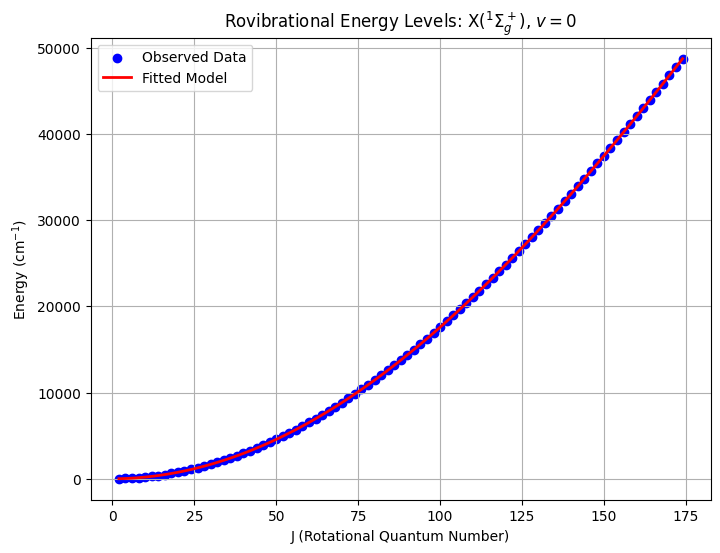

In [82]:
# Plot observed vs predicted energies
J_fit = np.linspace(min(J_values), max(J_values), 100)  # Generate smooth J values for the fit
E_predicted = rovibrational_energy(J_fit, T_e, B, D_e)

plt.figure(figsize=(8, 6))
plt.scatter(J_values, E_values, color='blue', label='Observed Data')
plt.plot(J_fit, E_predicted, color='red', label='Fitted Model', linewidth=2)
plt.xlabel('J (Rotational Quantum Number)')
plt.ylabel('Energy (cm$^{-1}$)')
plt.title(r'Rovibrational Energy Levels: X($^1\Sigma^+_g$), $v = 0$')
plt.legend()
plt.grid()
plt.show()

In [83]:
# NIST constants
T_e_nist = 0
B_e_nist = 1.81984
D_e_nist = 6.92e-6

# Fitted constants
T_e_fitted = -0.919753
B_fitted = 1.811087
D_e_fitted = 6.924e-6

# Calculate percentage differences
B_diff = (B_fitted - B_e_nist) / B_e_nist * 100
D_e_diff = (D_e_fitted - D_e_nist) / D_e_nist * 100

# Display results
print(f"Percentage Difference in B: {B_diff:.2f}%")
print(f"Percentage Difference in D_e: {D_e_diff:.2f}%")
print(f"T_e discrepancy: {T_e_fitted - T_e_nist:.2f} cm^-1")

Percentage Difference in B: -0.48%
Percentage Difference in D_e: 0.06%
T_e discrepancy: -0.92 cm^-1


### Part 2: Reproduce the Heat Capacity

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

In [69]:
import requests
import shutil

# Define URLs and file names
files_to_download = {
    'heat_capacity': 'https://exomol.com/db/C2/12C2/8states/12C2__8states.cp',
    'partition_function': 'https://exomol.com/db/C2/12C2/8states/12C2__8states.pf'
}

# Function to download files
def download_file(url, filename):
    with requests.get(url, stream=True) as response:
        if response.status_code == 200:
            with open(filename, 'wb') as f:
                shutil.copyfileobj(response.raw, f)
            print(f"File downloaded successfully: {filename}")
        else:
            print(f"Failed to download file. Status code: {response.status_code}")

# Download heat capacity and partition function files
for name, url in files_to_download.items():
    download_file(url, f"{name}.txt")

File downloaded successfully: heat_capacity.txt
File downloaded successfully: partition_function.txt


In [70]:
import pandas as pd
import matplotlib.pyplot as plt

# Load heat capacity data
file_path = "heat_capacity.txt"
heatcap = pd.read_csv(file_path, names=["T", "cp"], sep=r"\s+", comment='#')
print(heatcap.head())
print(" ")

       T       cp
0  200.0  40.2882
1  201.0  40.3866
2  202.0  40.4836
3  203.0  40.5791
4  204.0  40.6731
 


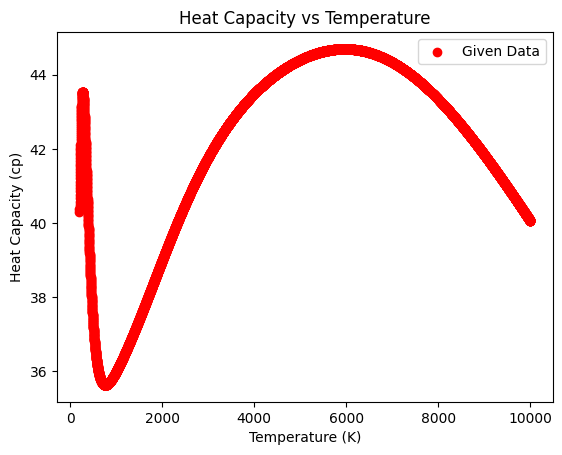

In [71]:
# Extract features and target variable
temperature = heatcap['T'].to_numpy().reshape(-1, 1) 
heat_capacity = heatcap['cp'].to_numpy()

# Data Plotting
plt.scatter(temperature, heat_capacity, color='red', label='Given Data')
plt.xlabel('Temperature (K)')
plt.ylabel('Heat Capacity (cp)')
plt.title('Heat Capacity vs Temperature')
plt.legend()
plt.show()

In [74]:
X_train, X_test, Y_train, Y_test = train_test_split(temperature, heat_capacity , test_size=0.2, random_state=42)

# Apply Kernel Ridge Regression model
krr = KernelRidge(kernel='rbf', alpha=0.001, gamma=0.01)
krr.fit(X_train, Y_train)

Y_pred_train = krr.predict(X_train)
Y_pred_test = krr.predict(X_test)

In [75]:
# Evaluate the model
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred_test))
r2 = r2_score(Y_test, Y_pred_test)
mae = mean_absolute_error(Y_test, Y_pred_test)

print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")
print(f"MAE: {mae:.3f}")

RMSE: 0.015
R²: 1.000
MAE: 0.005


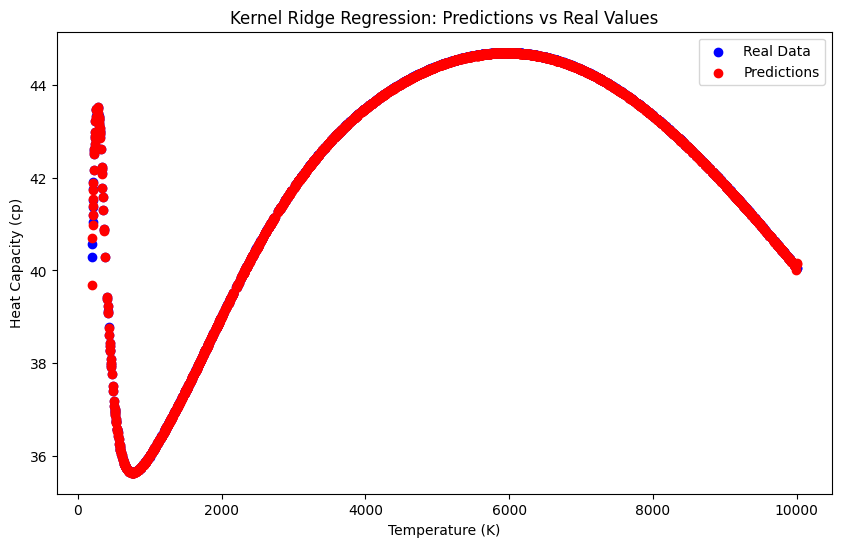

In [76]:
# Plot predictions vs real data
plt.figure(figsize=(10, 6))
plt.scatter(X_test, Y_test, color='blue', label='Real Data')
plt.scatter(X_test, Y_pred_test, color='red', label='Predictions')
plt.xlabel('Temperature (K)')
plt.ylabel('Heat Capacity (cp)')
plt.title('Kernel Ridge Regression: Predictions vs Real Values')
plt.legend()
plt.show()

### Description: 
The models is pretty good as seen from evaluation parameters and also visually from the fit

## Part 3: Reproduce Partition Function

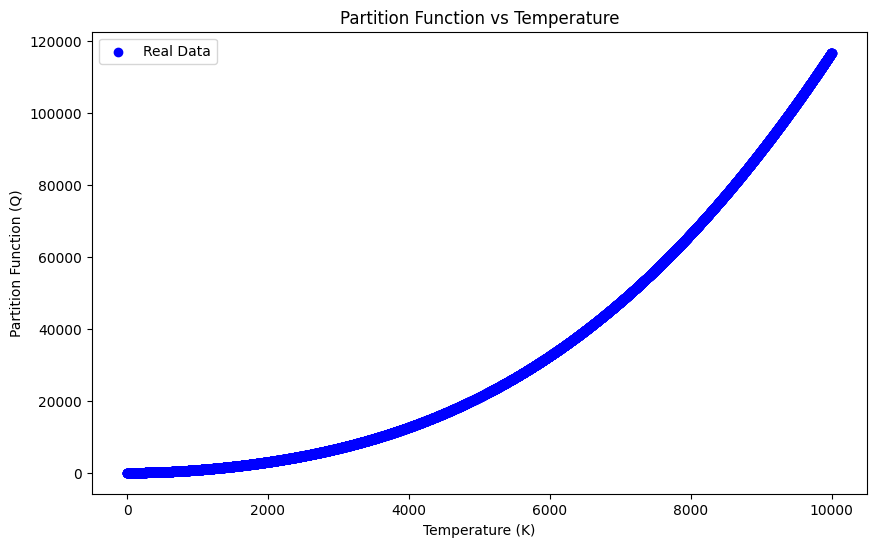

In [84]:
import pandas as pd
import matplotlib.pyplot as plt

# Load partition function data
file_path_pf = "partition_function.txt"
partition_data = pd.read_csv(file_path_pf, names=["T", "Q"], sep=r"\s+", comment='#')

# Display the first few rows
# print(partition_data.head())
# print(" ")

# Extract independent and dependent variables
temperature_pf = partition_data['T'].values.reshape(-1, 1)  # Ensure 2D array
partition_function = partition_data['Q'].values

# Visualize the data
plt.figure(figsize=(10, 6))
plt.scatter(temperature_pf, partition_function, color='blue', label='Real Data')
plt.xlabel('Temperature (K)')
plt.ylabel('Partition Function (Q)')
plt.title('Partition Function vs Temperature')
plt.legend()
plt.show()

In [85]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
X_train_pf, X_test_pf, Y_train_pf, Y_test_pf = train_test_split(
    temperature_pf, partition_function, test_size=0.2, random_state=42
)

# Apply Kernel Ridge Regression model
krr_pf = KernelRidge(kernel='rbf', alpha=0.001, gamma=0.01)
krr_pf.fit(X_train_pf, Y_train_pf)

# Make predictions
Y_pred_train_pf = krr_pf.predict(X_train_pf)
Y_pred_test_pf = krr_pf.predict(X_test_pf)

# Evaluate the model
rmse_pf = np.sqrt(mean_squared_error(Y_test_pf, Y_pred_test_pf))
r2_pf = r2_score(Y_test_pf, Y_pred_test_pf)
mae_pf = mean_absolute_error(Y_test_pf, Y_pred_test_pf)

print(f"RMSE (Partition Function): {rmse_pf:.4f}")
print(f"R² (Partition Function): {r2_pf:.4f}")
print(f"MAE (Partition Function): {mae_pf:.4f}")

RMSE (Partition Function): 7.6781
R² (Partition Function): 1.0000
MAE (Partition Function): 3.4702


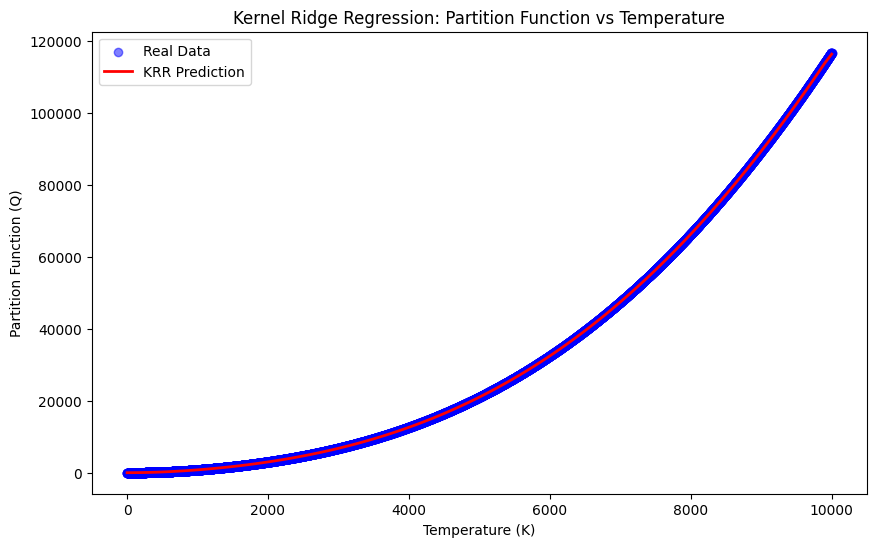

In [86]:
# Visualize real data and KRR predictions
import numpy as np

temperature_range_pf = np.linspace(temperature_pf.min(), temperature_pf.max(), 100).reshape(-1, 1)
partition_function_pred = krr_pf.predict(temperature_range_pf)

plt.figure(figsize=(10, 6))
plt.scatter(temperature_pf, partition_function, color='blue', label='Real Data', alpha=0.5)
plt.plot(temperature_range_pf, partition_function_pred, color='red', label='KRR Prediction', linewidth=2)
plt.xlabel('Temperature (K)')
plt.ylabel('Partition Function (Q)')
plt.title('Kernel Ridge Regression: Partition Function vs Temperature')
plt.legend()
plt.show()

### References
1. Stack Overflow. (2018). *Python file downloading fails.* Retrieved from [https://stackoverflow.com/questions/49041914/python-file-downloading-fails]
2. Stack Overflow. (2013). *Decompress bz2 files.* Retrieved from [https://stackoverflow.com/questions/16963352/decompress-bz2-files]
3. ExoMol Collaboration. (2024). *ExoMol Spectroscopy Data.* Retrieved from [https://arxiv.org/abs/2406.06347]
4. Pezzuto, M. (2024). *Machine Learning and Spectroscopy: Notebook 2.* Retrieved from [https://github.com/marcpezz/ML_presentation/blob/main/Notebook2/Spectroscopy.ipynb]